![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Tic-Tac-Toe
*(Adapted from: https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)*

In [11]:
#######################################################################
# Copyright (C)                                                       #
# 2016 - 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)           #
# 2016 Jan Hakenberg(jan.hakenberg@gmail.com)                         #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

## Imports
Python Libraries we need to run the code.

In [12]:
import numpy as np
import pickle
import pygame
from matplotlib import pyplot as plt
import os
from pathlib import Path
from tqdm import tqdm
import time
import warnings
from IPython.display import display
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Source Code
We will make sense of this in the upcoming lectures.

In [13]:
BOARD_ROWS = 3
BOARD_COLS = 3
BOARD_SIZE = BOARD_ROWS * BOARD_COLS

HIST_LEN = 3000

In [14]:
class State:
    def __init__(self):
        # the board is represented by an n * n array,
        # 1 represents a chessman of the player who moves first,
        # -1 represents a chessman of another player
        # 0 represents an empty position
        self.data = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.winner = None
        self.hash_val = None
        self.end = None
        self.window_surface = None
        self.window_size = [480, 480]
        self.cell_size = [160, 160]
        self.metadata = {"render_fps": 10}

        self.clock = pygame.time.Clock()
        self.render_mode = 'rgb_array' #'human' #'human' #


        rel_path = 'custom_envs/tabular_envs/envs/img'
        img_dir = os.path.join(Path(os.getcwd()), 'img')


        file_name = file_name = os.path.join(img_dir,  "ttt_empty.png")
        self.empty_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        file_name = os.path.join(img_dir, "ttt_cross.png")
        self.cross_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )


        file_name = os.path.join(img_dir, "ttt_circle.png")
        self.circle_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

    # compute the hash value for one state, it's unique
    def hash(self):
        if self.hash_val is None:
            self.hash_val = 0
            for i in np.nditer(self.data):
                self.hash_val = self.hash_val * 3 + i + 1
        return self.hash_val

    # check whether a player has won the game, or it's a tie
    def is_end(self):
        if self.end is not None:
            return self.end
        results = []
        # check row
        for i in range(BOARD_ROWS):
            results.append(np.sum(self.data[i, :]))
        # check columns
        for i in range(BOARD_COLS):
            results.append(np.sum(self.data[:, i]))

        # check diagonals
        trace = 0
        reverse_trace = 0
        for i in range(BOARD_ROWS):
            trace += self.data[i, i]
            reverse_trace += self.data[i, BOARD_ROWS - 1 - i]
        results.append(trace)
        results.append(reverse_trace)

        for result in results:
            if result == 3:
                self.winner = 1
                self.end = True
                return self.end
            if result == -3:
                self.winner = -1
                self.end = True
                return self.end

        # whether it's a tie
        sum_values = np.sum(np.abs(self.data))
        if sum_values == BOARD_SIZE:
            self.winner = 0
            self.end = True
            return self.end

        # game is still going on
        self.end = False
        return self.end

    # @symbol: 1 or -1
    # put chessman symbol in position (i, j)
    def next_state(self, i, j, symbol):
        new_state = State()
        new_state.data = np.copy(self.data)
        new_state.data[i, j] = symbol
        return new_state

    # print the board
    def render_state(self):
        mode = self.render_mode
        if self.window_surface is None:
            pygame.init()

            if mode == 'human':
                pygame.display.init()
                pygame.display.set_caption('Tic-Tac-Toe')
                self.window_surface = pygame.display.set_mode(self.window_size)
            elif mode == 'rgb_array':
                self.window_surface = pygame.Surface(self.window_size)
        assert (
                self.window_surface is not None
        ), "Something went wrong with pygame. This should never happen."


        for y in range(BOARD_ROWS):
            for x in range(BOARD_COLS):
                pos = (y * self.cell_size[0], x * self.cell_size[1])
                rect = (*pos, *self.cell_size)


                if self.data[x, y] == 1:
                    self.window_surface.blit(self.circle_img, pos)
                elif self.data[x, y] == -1:
                    self.window_surface.blit(self.cross_img, pos)
                elif self.data[x, y] == 0:
                    self.window_surface.blit(self.empty_img, pos)

                pygame.draw.rect(self.window_surface, (0, 0, 0), rect, 5)
        if mode == 'human':
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

def get_all_states_impl(current_state, current_symbol, all_states):
    for i in range(BOARD_ROWS):
        for j in range(BOARD_COLS):
            if current_state.data[i][j] == 0:
                new_state = current_state.next_state(i, j, current_symbol)
                new_hash = new_state.hash()
                if new_hash not in all_states:
                    is_end = new_state.is_end()
                    all_states[new_hash] = (new_state, is_end)
                    if not is_end:
                        get_all_states_impl(new_state, -current_symbol, all_states)


def get_all_states():
    current_symbol = 1
    current_state = State()
    all_states = dict()
    all_states[current_state.hash()] = (current_state, current_state.is_end())
    get_all_states_impl(current_state, current_symbol, all_states)
    return all_states


# all possible board configurations
all_states = get_all_states()


class Judger:
    # @player1: the player who will move first, its chessman will be 1
    # @player2: another player with a chessman -1
    def __init__(self, player1, player2):
        self.p1 = player1
        self.p2 = player2
        self.current_player = None
        self.p1_symbol = 1
        self.p2_symbol = -1
        self.p1.set_symbol(self.p1_symbol)
        self.p2.set_symbol(self.p2_symbol)
        self.current_state = State()

    def reset(self):
        self.p1.reset()
        self.p2.reset()

    def alternate(self):
        while True:
            yield self.p1
            yield self.p2

    #render_state: if True, print each board during the game
    def play(self, render_state=False, render_final_state=False, show_game=False):
        alternator = self.alternate()
        self.reset()
        current_state = State()
        if current_state.render_mode == 'rgb_array' and render_state:
            self.create_fig()
        self.p1.set_state(current_state)
        self.p2.set_state(current_state)
        if render_state:
            out = current_state.render_state()
            if out is not None:
                self.update_fig(out)
        while True:
            player = next(alternator)
            i, j, symbol = player.act()
            while i == -1:  # -1 if a key is pressed, that is not in the keylist
                i, j, symbol = player.act()
            next_state_hash = current_state.next_state(i, j, symbol).hash()
            current_state, is_end = all_states[next_state_hash]
            self.p1.set_state(current_state)
            self.p2.set_state(current_state)
            if show_game:
                time.sleep(0.5)
            if render_state:
                out = current_state.render_state()
                if out is not None:
                    self.update_fig(out)
            if is_end:
                if render_final_state:
                    out = current_state.render_state()
                    if out is not None:
                        self.update_fig(out)
                return current_state.winner

    def create_fig(self):
        self.fig = plt.figure(figsize=(5, 5))
        self.hfig = display(self.fig, display_id=True)

    def update_fig(self, frame):
        plt.clf()
        plt.axis('off')
        plt.imshow(frame)
        self.hfig.update(self.fig)
        time.sleep(0.25 / 1)



# AI player
class Player:
    # @step_size: the step size to update estimations
    # @epsilon: the probability to explore
    def __init__(self, step_size=0.1, epsilon=0.1):
        self.estimations = dict()
        self.step_size = step_size
        self.epsilon = epsilon
        self.states = []
        self.greedy = []
        self.symbol = 0
        self.cell_values = []
        self.win_rates = []
        self.results = []

    def reset(self):
        self.states = []
        self.greedy = []

    def set_state(self, state):
        self.states.append(state)
        self.greedy.append(True)

    def set_symbol(self, symbol):
        self.symbol = symbol
        for hash_val in all_states:
            state, is_end = all_states[hash_val]
            if is_end:
                if state.winner == self.symbol:
                    self.estimations[hash_val] = 1.0
                elif state.winner == 0:
                    # we need to distinguish between a tie and a lose
                    self.estimations[hash_val] = 0.5
                else:
                    self.estimations[hash_val] = 0
            else:
                self.estimations[hash_val] = 0.5

    # update value estimation
    def backup(self):
        states = [state.hash() for state in self.states]

        for i in reversed(range(len(states) - 1)):
            state = states[i]
            td_error = self.greedy[i] * (
                    self.estimations[states[i + 1]] - self.estimations[state]
            )
            self.estimations[state] += self.step_size * td_error

    # choose an action based on the state
    def act(self):
        state = self.states[-1]
        next_states = []
        next_positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if state.data[i, j] == 0:
                    next_positions.append([i, j])
                    next_states.append(state.next_state(
                        i, j, self.symbol).hash())

        if np.random.rand() < self.epsilon:
            action = next_positions[np.random.randint(len(next_positions))]
            action.append(self.symbol)
            self.greedy[-1] = False
            return action

        values = []
        for hash_val, pos in zip(next_states, next_positions):
            values.append((self.estimations[hash_val], pos))

        self.cell_values = values
        # to select one of the actions of equal value at random due to Python's sort is stable
        np.random.shuffle(values)
        values.sort(key=lambda x: x[0], reverse=True)
        action = values[0][1]
        action.append(self.symbol)
        return action

    def save_policy(self):
        with open('policy_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'wb') as f:
            pickle.dump(self.estimations, f)

    def load_policy(self):
        with open('policy_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'rb') as f:
            self.estimations = pickle.load(f)

    def load_pretrained_policy(self):
        with open('./utils/policy_pretrained.bin', 'rb') as f:
            self.estimations = pickle.load(f)

    def save_metrics(self):
        with open('metrics_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'wb') as f:
            metrics = {'win_rates': self.win_rates, 'results': self.results}
            pickle.dump(metrics, f)

    def load_metrics(self):
        with open('metrics_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'rb') as f:
            metrics = pickle.load(f)
            self.win_rates = metrics['win_rates']
            self.results = metrics['results']


# human interface
# input a number to put a chessman
# | q | w | e |
# | a | s | d |
# | z | x | c |
class HumanPlayer:
    def __init__(self, **kwargs):
        self.symbol = None
        self.keys = ['q', 'w', 'e', 'a', 's', 'd', 'z', 'x', 'c']
        self.state = None

    def reset(self):
        pass

    def set_state(self, state):
        self.state = state

    def set_symbol(self, symbol):
        self.symbol = symbol

    def act(self):
        self.state.render_state()
        key = input("Input your position:")
        if key in self.keys:  # if a legal key was pressed
            data = self.keys.index(key)
        else:
            print("Invalid input! Please try again!")
            return -1, -1, self.symbol

        i = data // BOARD_COLS
        j = data % BOARD_COLS

        if self.state.data[i][j] == 0:  # if field was not chosen before
            return i, j, self.symbol
        else:
            print("This field is already occupied! Please try again!")
            return -1, -1, self.symbol


''' Trains the players '''
def train(epochs, print_every_n=5000):
    player1 = Player(epsilon=0.01)
    player2 = Player(epsilon=0.01)
    judger = Judger(player1, player2)
    for i in tqdm(range(1, epochs + 1)):
        winner = judger.play(render_state=False)
        if winner == 1:
            player1.results.append(1)
            player2.results.append(0)
        elif winner == -1:
            player1.results.append(0)
            player2.results.append(1)
        else:
            player1.results.append(0)
            player2.results.append(0)
        if i % print_every_n == 0:
            print('Epoch %d, player 1 winrate: %.02f, player 2 winrate: %.02f' % (i, player1.win_rates[-1], player2.win_rates[-1]))

        hist = min(len(player1.results), HIST_LEN)
        player1.win_rates.append(sum(player1.results[-hist:])/hist)
        player2.win_rates.append(sum(player2.results[-hist:])/hist)

        player1.backup()
        player2.backup()
        judger.reset()
    player1.save_policy()
    player1.save_metrics()
    player2.save_policy()
    player2.save_metrics()
    return player1, player2


def retrain(epochs, print_every_n=5000):
    player1 = Player(epsilon=0.01)
    player2 = Player(epsilon=0.01)
    judger = Judger(player1, player2)
    player1.load_policy()
    player1.load_metrics()
    player2.load_policy()
    player2.load_metrics()
    for i in tqdm(range(1, epochs + 1)):
        winner = judger.play(render_state=False)
        if winner == 1:
            player1.results.append(1)
            player2.results.append(0)
        elif winner == -1:
            player1.results.append(0)
            player2.results.append(1)
        else:
            player1.results.append(0)
            player2.results.append(0)
        if i % print_every_n == 0:
            print('Epoch %d, player 1 winrate: %.02f, player 2 winrate: %.02f' % (i, player1.win_rates[-1], player2.win_rates[-1]))

        hist = min(len(player1.results), HIST_LEN)
        player1.win_rates.append(sum(player1.results[-hist:]) / hist)
        player2.win_rates.append(sum(player2.results[-hist:]) / hist)

        player1.backup()
        player2.backup()
        judger.reset()
    player1.save_policy()
    player1.save_metrics()
    player2.save_policy()
    player2.save_metrics()
    return player1, player2


''' Lets the players play against each other '''
def compete(turns):
    player1 = Player(epsilon=0)
    player2 = Player(epsilon=0)
    judger = Judger(player1, player2)
    player1.load_policy()
    player2.load_policy()
    player1_win = 0.0
    player2_win = 0.0
    for _ in range(turns):
        winner = judger.play()
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        judger.reset()
    print('%d turns, player 1 winrate %.02f, player 2 winrate %.02f' % (turns, player1_win / turns, player2_win / turns))


# The game is a zero sum game. If both players are playing with an optimal strategy, every game will end in a tie.
# So we test whether the AI can guarantee at least a tie if it goes second.
def play(load_pretrained=False):
    cont = True
    while cont:
        player1 = HumanPlayer()
        player2 = Player(epsilon=0)
        judger = Judger(player1, player2)
        if load_pretrained:
            player2.load_pretrained_policy()
        else:
            player2.load_policy()
        winner = judger.play(render_state=True, render_final_state=True, show_game=True)
        if winner == player2.symbol:
            print("You lose!")
            cont = continue_input()
        elif winner == player1.symbol:
            print("You win!")
            cont = continue_input()
        else:
            print("It is a tie!")
            cont = continue_input()

def continue_input():
    key = input("Press 'c' to continue or 'q' to quit:")
    if key == 'c':
        return True
    elif key == 'q':
        return False
    else:
        print('Faulty input!')
        continue_input()

        
def render_training(winrate1, winrate2, nbr_games):
    fig = plt.figure()
    # plot of player 1
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, nbr_games, nbr_games), winrate1, color="blue")
    plt.xlabel("Number of Runs")
    plt.ylabel("Winrate")
    plt.ylim([0, 1])
    plt.title("Player 1")
    # Plot of player 2
    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(0, nbr_games, nbr_games), winrate2, color="red")
    plt.xlabel("Number of Runs")
    plt.ylim([0, 1])
    plt.title("Player 2")
    #fig.show()

# Test Setup
Two Tic-Tac-Toe agents are trained in self play for 100,000 games.


In [15]:
nbr_initial_training_games = 50
nbr_retraining_games = 99950
nbr_evaluation_games = 100

### Initial Training

We first train the agents for 50 games and check what they have learned.

We firstly plot the win rate during training, meaning the percentage of games the respective agent won. It is important to note, that if both agents act optimally, nether of them can win the game and all games will result in a tie. Thus, optimal behavior corresponds to both agents have a win rate of one.

Train agents for 50 games.


100%|██████████| 50/50 [00:00<00:00, 101.19it/s]


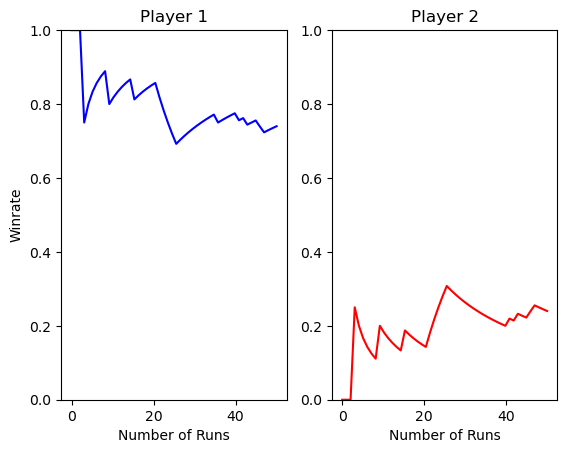

In [16]:
print('Train agents for ' + str(nbr_initial_training_games) + ' games.')
player1, player2 = train(nbr_initial_training_games)
render_training(player1.win_rates, player2.win_rates, nbr_initial_training_games)

### Evaluation in self-play

Now we check the winrates of both agents, if we let them compete for 100 games without learning.

In [17]:
print('Evaluate for ' + str(nbr_evaluation_games) + ' games of self play.')
compete(nbr_evaluation_games)

Evaluate for 100 games of self play.
100 turns, player 1 winrate 0.76, player 2 winrate 0.10


### Evaluation with human interaction

Let's try it ourselves! We play against agent 2. Our token is the blue circle, the agent's token is the red cross.

*Note*: The game is based on the QWERTY-layout, so to use the bottom-left corner with a QWERTZ-layout, you have to press *z* instead of *y*

Play against agent trained for 50 games.


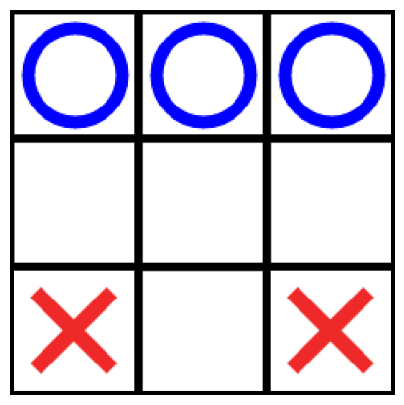

You win!


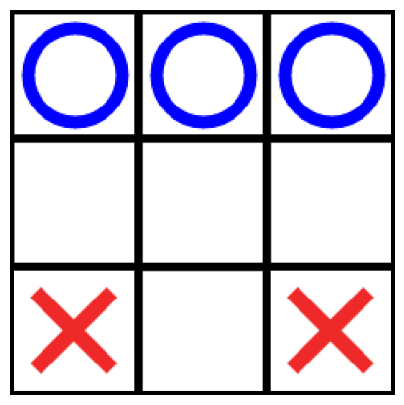

In [18]:
print('Play against agent trained for ' + str(nbr_initial_training_games) + ' games.')
play()

### Continuation of Training

Well, seems the agent hasn't really gotten the game, yet. Let's train both agents for more games and see what we get.

In [19]:
print('Continue training agents for ' + str(nbr_retraining_games) + ' games.')
player1, player2 = retrain(nbr_retraining_games)  # train a lot
render_training(player1.win_rates, player2.win_rates, nbr_initial_training_games + nbr_retraining_games)
print('Evaluate for ' + str(nbr_evaluation_games) + ' games of self play.')
compete(nbr_evaluation_games)
print('Play against agent trained for ' + str(nbr_initial_training_games + nbr_retraining_games) + ' games.')
play()

Continue training agents for 99950 games.


  1%|          | 902/99950 [00:10<20:09, 81.91it/s]

### Play against pretrained agent
To speed things up a little, we have prepared a pretrained agent to play against.

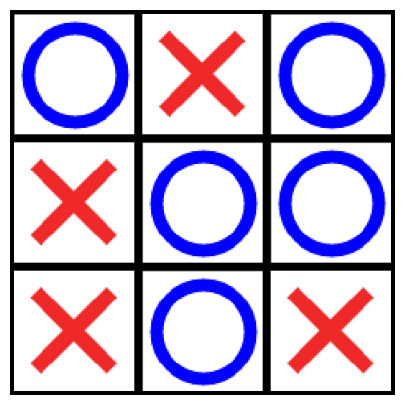

This field is already occupied! Please try again!
It is a tie!


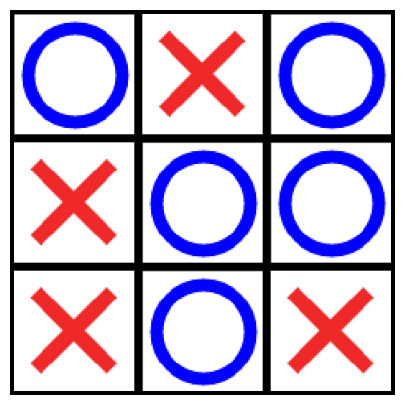

In [ ]:
play(load_pretrained=True)